# $D_3$ and $E_8$ Lattice Quantization

## Introduction
This notebook demonstrates the encoding and decoding of a normally distributed random variable using the lattices $D_3$ and $E_8$. 
We will build nested lattices, implement the closest-point algorithms for these lattices, and explore how scaling affects the error rate in decoding.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

## Closest Point Algorithm for the $D_n$ Lattice
The lattice $D_n$ consists of points where the sum of components is even. Given a point in $\mathbb{R}^n$, we round it to the nearest integers and check which of the two possible points in $D_n$ (with even or odd sums) is closest.

In [26]:
def g_x(x):
    """
    Compute g(x) by rounding the vector x to the nearest integers, 
    but flip the rounding for the coordinate farthest from an integer.
    """
    f_x = np.round(x)

    fractional_parts = np.abs(x - f_x)
    farthest_index = np.argmax(fractional_parts)

    g_x_ = f_x.copy()
    if g_x_[farthest_index] > x[farthest_index]:
        g_x_[farthest_index] = np.floor(x[farthest_index])
    else:
        g_x_[farthest_index] = np.ceil(x[farthest_index])

    return g_x_

def closest_point_Dn(x):
    """
    Find the closest point in the D_n lattice for a given vector x.
    Uses g_x function for flipping rounding.
    """
    f_x = np.round(x)
    g_x_res = g_x(x)
    return f_x if np.sum(f_x) % 2 == 0 else g_x_res

## Closest Point Algorithm for the $E_8$ Lattice

The lattice $E_8$ is constructed from $D_8$ and a coset. The closest point in $E_8$ is either the closest point in $D_8$ or the point obtained by adding $(\frac{1}{2}, \frac{1}{2}, ..., \frac{1}{2})$ to the coordinates of $D_8$.

In [27]:
def closest_point_En(x):
    """
    Find the closest point in the E_8 lattice for a given vector x.
    Uses g_x function for flipping rounding.
    """
    y_0 = np.round(x) if np.sum(np.round(x)) % 2 == 0 else g_x(x)
    
    f_x_shifted = np.round(x - 0.5)
    g_x_shifted = g_x(x - 0.5)
    
    y_1 = f_x_shifted + 0.5 if np.sum(f_x_shifted) % 2 == 0 else g_x_shifted + 0.5

    if np.linalg.norm(x - y_0) < np.linalg.norm(x - y_1):
        return y_0
    else:
        return y_1

## Encoding and Decoding

Encoding:
we map the random vector  $x \in \mathbb{R}^n$ to the closest coset in the fine lattice that lies within a shaping region defined by the coarse lattice (a scaled version of the fine lattice).
Specifically, the goal is to locate the closest lattice coset in the Voronoi region of the coarse lattice centered around the origin. The coset representative for this region is encoded, allowing us to represent  x  more compactly using a coarse lattice approximation.

Decoding:
Given the compressed shape of the coset (determined by the coarse lattice), the decoder identifies the corresponding coset within the Voronoi region.

In [28]:
class Quantizer:
    def __init__(self, G, Q_nn, beta=1, q=1):
        self.beta = beta
        self.q = q
        self.G = G
        self.Q_nn = Q_nn

    def encode(self, x):
        fine_x = self.Q_nn(x / self.beta) * self.beta
        coarse_x = self.Q_nn(x / self.q) * self.q
        x_e = fine_x - coarse_x
        encoded = np.dot(x_e, np.linalg.inv(self.G).T)
        encoded_mod_q = np.mod(encoded, self.q)
        return encoded_mod_q

    def decode(self, y):
        x_hat = np.dot(self.G, y)
        closest_coarse = self.q * self.Q_nn(x_hat / self.q)
        return x_hat - closest_coarse

## Step 5: Error Measure for the quantizer

In [29]:
def calculate_mse(x, decoded_x):
    """
    Calculate the Mean Squared Error between the original vector x and the decoded vector decoded_x.
    """
    return (np.linalg.norm(x - decoded_x) ** 2) / x.size

In [30]:
def calculate_avg_error(d, q, G, Q_nn, num_samples=50):
    errors = []
    betas = np.linspace(0.01, q, 5)
    
    for beta in betas:
        quantizer = Quantizer(G, Q_nn)
        avg_error = 0
        
        for _ in range(num_samples):
            x = np.random.normal(0, 10, d)
            encoded_x = quantizer.encode(x)
            decoded_x = quantizer.decode(encoded_x)
            error = calculate_mse(x, decoded_x)
            avg_error += error
        
        avg_error /= num_samples
        errors.append(avg_error)
    best_beta_index = np.argmin(errors)
    best_beta = betas[best_beta_index]
    # plot_beta_results(betas, errors, best_beta)
    return errors, best_beta, errors[best_beta_index]

def plot_beta_results(betas, errors, best_beta):
    plt.figure(figsize=(10, 6))
    plt.plot(betas, errors, marker='o')
    plt.title('Distortion vs. Beta')
    plt.xlabel('Beta')
    plt.ylabel('Average Distortion (Error)')
    plt.grid()
    plt.axvline(x=best_beta, color='r', linestyle='--', label=f'Best Beta: {best_beta:.2f}')
    plt.legend()
    plt.show()

def plot_q_results(lattice_name, q_values, average_errors):
    plt.figure(figsize=(12, 6))
    plt.plot(q_values, average_errors, marker='o', label='Average Error')
    plt.title(f'Average Distortion vs. q for {lattice_name} Lattice')
    plt.xlabel('q')
    plt.ylabel('Average Distortion (Error)')
    plt.grid()

    for q in q_values:
        plt.axvline(x=q, color='gray', linestyle='--', alpha=0.5)

    plt.legend()
    plt.show()
    
def run_experiment(lattice_name, q_values, d, G, Q_nn, num_samples=50):
    results = {}
    for q in q_values:
        errors, best_beta, smallest_error = calculate_avg_error(d, q, G, Q_nn, num_samples)
        results[q] = (best_beta, smallest_error)

    q_list = list(results.keys())
    average_errors = [results[q][1] for q in q_list]
    
    plot_q_results(lattice_name, q_list, average_errors)
    
    for q in q_list:
        print(f"Best beta for q={q}: {results[q][0]:.2f} with average error: {results[q][1]:.4f}")


## Scaling Experiment for $D_3$

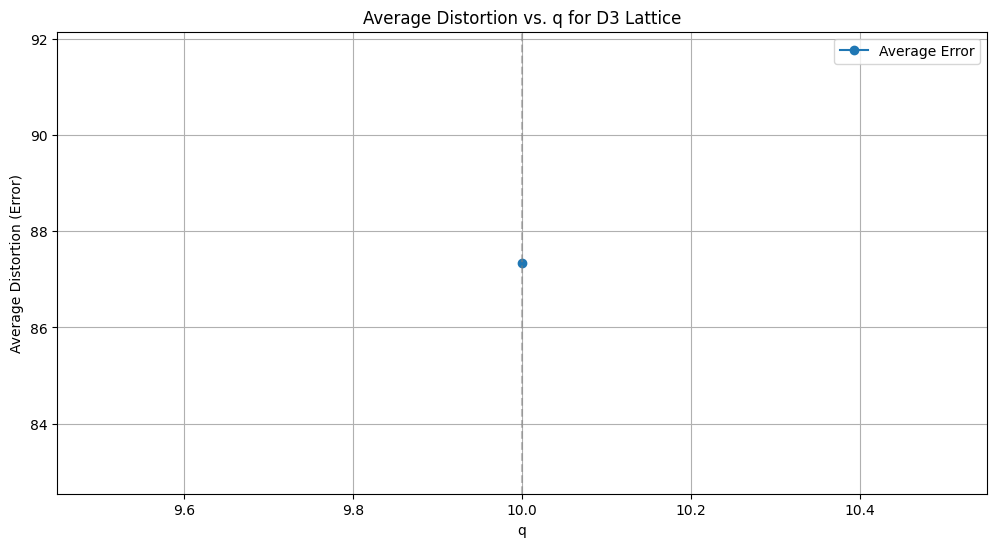

Best beta for q=10: 0.01 with average error: 87.3458


In [31]:
G_D_3 = np.array([
    [ 1, -1,  0],
    [ 0,  1, -1],
    [ 0,  1,  1]
]).transpose()


num_samples = 100  
q_values = [10]

run_experiment("D3", q_values, 3, G_D_3, closest_point_Dn, num_samples)

## Scaling Experiment for $E_8$

In [32]:
# G_E_8 = np.array([
#     [2,  0,  0,  0,  0,  0,  0,  0],
#     [-1,  1,  0,  0,  0,  0,  0,  0],
#     [0,  -1,  1,  0,  0,  0,  0,  0],
#     [0,  0,  -1,  1,  0,  0,  0,  0],
#     [0,  0,  0,  -1,  1,  0,  0,  0],
#     [0,  0,  0,  0,  -1,  1,  0,  0],
#     [0,  0,  0,  0,  0,  -1,  1,  0],
#     [0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5]
# ]).T
# 
# # Parameters
# num_samples = 50  # number of random samples
# q_values = np.linspace(2, 100, 10).astype(int)  # 50 q values between 2 and 100
# run_experiment("E8", q_values, 8, G_E_8, closest_point_En, num_samples)

## Conclusion

In this notebook, we implemented the closest-point algorithms for lattices $D_n$ and $E_8$, encoded and decoded random Gaussian vectors using these lattices, and explored how scaling affects error rates. As we can see from the plot, larger scaling factors tend to reduce the error, but eventually, the error stabilizes due to the structure of the lattice.